# Online Purchase Propensity

## Project Overview

This [Kaggle](https://www.kaggle.com/benpowis/customer-propensity-to-purchase-data) dataset 
tracks a day's worth of user visits for a ficticious online retail website. 607055 rows, 25 
columns, and (excluding "UserID") entirely composed of binary data. Features #2 through #24 track 
various user states and actions across the website, while #25 denotes whether the user session 
resulted in an order. The end goal is to prototype and fine tune a couple different machine 
learning models to predict user propensity to purchase for the client / website owner.

## Data Exploration

In [1]:
# module imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from hyperopt import fmin, hp, STATUS_OK, tpe, Trials
from imblearn.ensemble import BalancedRandomForestClassifier
from IPython.display import Markdown, display
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# markdown printer
def printmd(text):
    display(Markdown(text))

In [3]:
# importing data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
printmd('**Train info:**')
print(train.info(), '\n')
printmd('**Test info:**')
print(test.info())

**Train info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455401 entries, 0 to 455400
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   UserID                   455401 non-null  object
 1   basket_icon_click        455401 non-null  int64 
 2   basket_add_list          455401 non-null  int64 
 3   basket_add_detail        455401 non-null  int64 
 4   sort_by                  455401 non-null  int64 
 5   image_picker             455401 non-null  int64 
 6   account_page_click       455401 non-null  int64 
 7   promo_banner_click       455401 non-null  int64 
 8   detail_wishlist_add      455401 non-null  int64 
 9   list_size_dropdown       455401 non-null  int64 
 10  closed_minibasket_click  455401 non-null  int64 
 11  checked_delivery_detail  455401 non-null  int64 
 12  checked_returns_detail   455401 non-null  int64 
 13  sign_in                  455401 non-null  int64 
 14  saw_checkout        

**Test info:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151655 entries, 0 to 151654
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   UserID                   151655 non-null  object
 1   basket_icon_click        151655 non-null  int64 
 2   basket_add_list          151655 non-null  int64 
 3   basket_add_detail        151655 non-null  int64 
 4   sort_by                  151655 non-null  int64 
 5   image_picker             151655 non-null  int64 
 6   account_page_click       151655 non-null  int64 
 7   promo_banner_click       151655 non-null  int64 
 8   detail_wishlist_add      151655 non-null  int64 
 9   list_size_dropdown       151655 non-null  int64 
 10  closed_minibasket_click  151655 non-null  int64 
 11  checked_delivery_detail  151655 non-null  int64 
 12  checked_returns_detail   151655 non-null  int64 
 13  sign_in                  151655 non-null  int64 
 14  saw_checkout        

Both dataframes are quite clean, no missing or null values. Dropping the "UserID" column as it 
won't be needed in the remaining analysis.

In [4]:
# dropping userid
train.drop("UserID", axis = 1, inplace = True)
test.drop("UserID", axis = 1, inplace = True)

In [5]:
# class balances
printmd('**Train balance:**')
print(train.ordered.value_counts()/train.shape[0], '\n')
printmd('**Test balance:**')
print(test.ordered.value_counts()/test.shape[0])

**Train balance:**

0    0.958074
1    0.041926
Name: ordered, dtype: float64 



**Test balance:**

0    1.0
Name: ordered, dtype: float64


This dataset suffers from a heavy class imbalance, something we will need to keep in mind 
when building predictive models sensitive to said imbalance. Note that the test dataset is 
composed entirely of "0" "ordered" instances. This won't have any serious impact on the model's 
predictive abilities, but it will likely impact our ability to assess said ability with certain 
metrics.

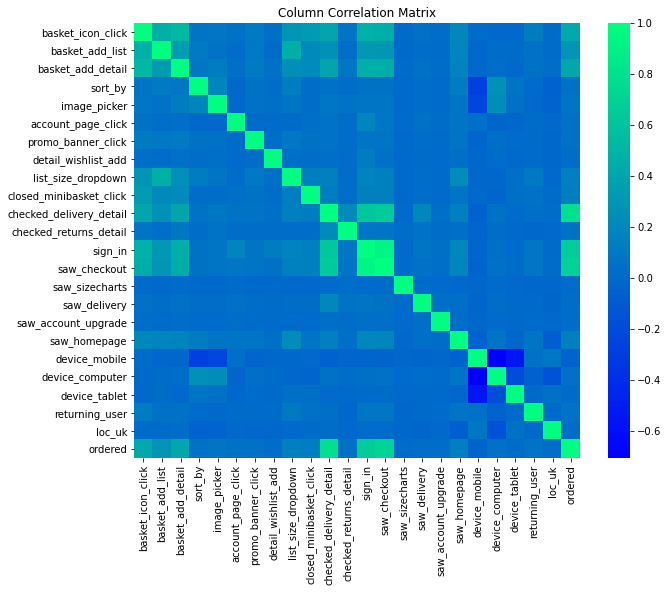

In [6]:
# correlation plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
sb.heatmap(train.corr(), cmap = 'winter', ax = ax)
ax.set_title('Column Correlation Matrix')
plt.show()

The above heatmap helps visualize predictor-predictor and predictor-response correlations at a 
glance. "checked_delivery_detail", "sign_in", and "saw_checkout" all show promising amounts of 
correlation with the response variable, albeit with similarly high levels of multicollinearity 
between themselves.

A more quantitative method of assessing multicollinearity amongst the predictors would be to 
be to calculate variance inflation factors (VIFs).

In [7]:
# x-y splits
X_train = train.iloc[:, :-1]
y_train = train['ordered']
X_test = test.iloc[:, :-1]
y_test = test['ordered']

In [8]:
# calculating vifs
vifs = pd.DataFrame(X_train.columns, columns = ['col'])
vifs.loc[:, 'vif'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vifs = vifs.sort_values('vif', ascending = False).set_index('col', drop = True)
print(vifs)

                               vif
col                               
loc_uk                   14.688576
device_mobile            11.780301
sign_in                   9.786845
saw_checkout              9.661590
device_computer           3.687012
device_tablet             3.110726
returning_user            2.209838
checked_delivery_detail   2.129950
basket_icon_click         2.047719
basket_add_detail         1.780923
list_size_dropdown        1.765275
basket_add_list           1.674745
saw_homepage              1.579528
sort_by                   1.185449
closed_minibasket_click   1.151321
image_picker              1.138775
account_page_click        1.130253
checked_returns_detail    1.075586
saw_delivery              1.066949
detail_wishlist_add       1.066770
promo_banner_click        1.042587
saw_account_upgrade       1.005718
saw_sizecharts            1.001376


The top four variables in this list make up those first to be addressed: "loc_uk", 
"device_mobile", "sign_in", and "saw_checkout". For now, though, these variables will be left 
alone.

## Building Models

### 1. BernoulliNB (bnb)

The first model will serve as the baseline to beat, a derivative of the naive bayes theorem specifically for boolean 
features. For reasons covered later on, this model should perform well despite some hidden gotchas in this 
particular dataset.

In [9]:
# model construction
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)
printmd('**Classification Report**')
print(classification_report(y_test, y_pred, digits = 4, zero_division = 0))

**Classification Report**

              precision    recall  f1-score   support

           0     1.0000    0.9800    0.9899    151655
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9800    151655
   macro avg     0.5000    0.4900    0.4950    151655
weighted avg     1.0000    0.9800    0.9899    151655



The impact of only having one class in the test dataset is evident in the class "1" f1 score (0) 
and macro average f1 score (.495). Both metrics suffer with no true positives for class "1"; 
false positives make up the only "1" class predictions and therefore tank precision and recall. 
For a better representation of predictive performance on a two-class test dataset, we turn to 
stratified cross validation of the training dataset.

In [10]:
# validation function
def model_validation(clf, X, y, format = 'report'):
    '''
    Stratified cross validation function, outputs either classification_report or f1_score.

        Arguments:
            clf (object): classifier, supports .fit / .predict
            X (array): feature array, n x d
            y (array): label array, n x 1
            format (string): output format, 'report' or 'score'
        
        Returns:
            result (string / float): validation metric, depends on format variable
    '''
    preds = []
    tests = []
    skf = StratifiedKFold(shuffle = True)
    for train_ind, test_ind in skf.split(X, y):
        train_X, test_X = X.values[train_ind], X.values[test_ind]
        train_y, test_y = y[train_ind], y[test_ind]
        clf.fit(train_X, train_y)
        pred_y = clf.predict(test_X)
        preds.append(pred_y)
        tests.append(test_y)
    if format == 'report':
        result = classification_report(np.hstack(tests), np.hstack(preds), digits = 4)
    else:
        result = f1_score(np.hstack(tests), np.hstack(preds), average = 'macro')
    return result

In [11]:
# bernoulli validation
printmd('**Classification Report**')
bnb = BernoulliNB()
print(model_validation(bnb, X_train, y_train))

**Classification Report**

              precision    recall  f1-score   support

           0     0.9997    0.9810    0.9903    436308
           1     0.6959    0.9927    0.8182     19093

    accuracy                         0.9815    455401
   macro avg     0.8478    0.9869    0.9042    455401
weighted avg     0.9869    0.9815    0.9830    455401



Now that the naive bayes model is predicting on instances from both classes, we get a more 
realistic look at predictive performance. Our cross validated model's precision for class "1" 
does leave something to be desired, something we hope to improve with another model. 

One quick note, above it was mentioned that the heavy class imbalance would impact models 
sensitive to said imbalance. BernoulliNB is a probabilistic, binary classification model (in this 
specific instance), and therefore is mostly unaffected. Any deterministic models we attempt to 
implement will need to take steps to address this imbalance.

### 2. BalancedRandomForestClassifier (brf)

Enter "imbalanced-learn" (also "imblearn"), a Python library built for the explicit purpose 
of dealing with class imbalanced datasets. Touted for it's high degree of compatibility with 
scikit-learn, "imbalanced-learn" contains a hodge podge of resampling and 
sklearn-wrapped methods tailor-built for handling unbalanced datasets.

In contrast to sklearn's RandomForestClassifier, brf includes parameters to control random 
undersampling. Each weak learner in the bagged model is trained on an undersampled (with 
replacement) subset of the original dataset, albeit with a more favorable / equal balance of 
classes.

In [12]:
# parameter space
params = {
    'n_estimators': hp.quniform('n_estimators', 20, 80, 1),
    'max_depth': hp.quniform('max_depth', 1, 15, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 50, 1),
    'max_features': hp.quniform('max_features', 1, 23, 1),
    'sampling_strategy': hp.choice('sampling_strategy', ['majority', 'not minority', 'not majority', 'all']),
    'replacement': hp.choice('replacement', ['True', 'False']),
    'class_weight': hp.choice('class_weight', [None, 'balanced', 'balanced_subsample'])
}

In [13]:
# optimization function
def objective(params):
    keys = list(params.keys())
    floats = ['n_estimators', 'max_depth', 'min_samples_split', 'max_features']
    params = {k:(int(params[k]) if k in floats else params[k]) for k in keys}
    brf = BalancedRandomForestClassifier(**params, n_jobs = -1, random_state = 42)
    score = model_validation(brf, X_train, y_train, 'score')
    return {'loss': -score, 'status': STATUS_OK}

To eke out as much predictive performance as possible, we will be relying on HyperOpt for some
hyperparameter tuning. The fmin function below will test various combinations of 
hyperparameters from a pre-defined parameter space, using outcomes to guide it to the optimal 
set. Compared to GridSearch and RandomSearch, this translates to less time spent testing 
conditions with low chances of improving performance. 

In [14]:
# tuning model
trials = Trials()
best = fmin(fn = objective, space = params, algo = tpe.suggest, max_evals = 50, trials = trials)
sampling_strategy = ['majority', 'not minority', 'not majority', 'all']
replacement = ['True', 'False']
class_weight = [None, 'balanced', 'balanced_subsample']
for name in ['sampling_strategy', 'replacement', 'class_weight']:
    best[name] = eval(f'{name}[best[name]]')
for name in ['n_estimators', 'max_depth', 'min_samples_split', 'max_features']:
    best[name] = int(best[name])
printmd('**Best Parameters**')
print(best, '\n')
printmd('**Best Macro F1 Score**')
print(-trials.best_trial['result']['loss'])

100%|██████████| 50/50 [12:57<00:00, 15.55s/trial, best loss: -0.9601817235826953]


**Best Parameters**

{'class_weight': None, 'max_depth': 11, 'max_features': 4, 'min_samples_split': 23, 'n_estimators': 47, 'replacement': 'True', 'sampling_strategy': 'not majority'} 



**Best Macro F1 Score**

0.9601817235826953


This second model and macro f1 score mark an improvement of ~.055 over the previous. Let's 
generate a classification report so we can compare per class f1 scores.

In [15]:
# model report
brf = BalancedRandomForestClassifier(**best, n_jobs = -1, random_state = 42)
printmd('**Classification Report**')
print(model_validation(brf, X_train, y_train))

**Classification Report**

              precision    recall  f1-score   support

           0     0.9994    0.9934    0.9964    436308
           1     0.8676    0.9874    0.9236     19093

    accuracy                         0.9932    455401
   macro avg     0.9335    0.9904    0.9600    455401
weighted avg     0.9939    0.9932    0.9934    455401



## Closing Thoughts

Swapping models resulted in f1 score net-positive changes for both classes, though only minimally 
so for class "0". The gains for class "1" were in precision, meaning more correct "1" predictions 
per overall "1" predictions; recall did suffer, but only minimally so. In a business context this 
would means fewer false positives and more false negatives, respectively, but in general better 
predictive abilities for class "1". Depending on client requirements these specific models could 
be re-weighted, though the end result would be a trade off between each class' predictive power.

Further exploration, post-project, would be to investigate more computationally complex models; 
XGBoost, LightGBM, and Catboost come to mind.